In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [2]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [3]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
datos.head()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
0,NaN,Jueves,2013-11-14,1,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 00:00:00
1,NaN,NaN,2013-11-14,2,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
2,NaN,NaN,2013-11-14,3,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
3,NaN,NaN,2013-11-14,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
4,NaN,NaN,2013-11-14,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00


In [4]:
datos.tail()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
55387,NaN,NaN,2020-03-09,20,12140.0,6879.0,26607.0,19358.0,10983.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 19:00:00
55388,NaN,NaN,2020-03-09,21,4313.0,31473.0,14942.0,3029.0,15129.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 20:00:00
55389,NaN,NaN,2020-03-09,22,98.0,54796.0,33875.0,22778.0,8490.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 21:00:00
55390,NaN,NaN,2020-03-09,23,803.0,57081.0,34073.0,36240.0,16482.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 22:00:00
55391,NaN,NaN,2020-03-09,24,7594.0,56351.0,39697.0,45519.0,22479.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 23:00:00


In [5]:
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [6]:
n_periods = 5*24

In [7]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314''GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [8]:
columna = columns[8]
columna

'GICIS309'

In [9]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [10]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        #model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [11]:
    data2 = datos[['hora',columna]]
    data2[columna] = (data2[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    #data2 = data2.dropna()
    data2

,hora,GICIS309
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0
...,...,...
2020-03-09 19:00:00,20,14.0
2020-03-09 20:00:00,21,14.0
2020-03-09 21:00:00,22,14.0


***

In [12]:
    #Se separará por hora del día, ya que cada hora se comporta diferente.
    xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
    ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]

In [13]:
    #El siguiente ciclo 'for' crea un DataFrame acomodado por horas, de cada planta de generación.
    for i in range(1,25):
        hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
        xhr['Hora '+str(i)] = hrs
    xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1126.0,1135.0,...,10386.0,9339.0,6533.0,1822.0,120.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1452.0,6446.0,...,10314.0,9188.0,6631.0,1962.0,109.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1594.0,5912.0,...,10258.0,9201.0,6045.0,1914.0,95.0,46.0,46.0,46.0,46.0,46.0
4,46.0,24.0,0.0,0.0,0.0,0.0,0.0,11.0,1452.0,6828.0,...,10397.0,9155.0,6526.0,1975.0,101.0,44.0,44.0,44.0,44.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,471.0,2869.0,5638.0,...,9765.0,7900.0,6890.0,3451.0,968.0,0.0,0.0,0.0,0.0,0.0
65,37.0,37.0,28.0,0.0,0.0,0.0,0.0,477.0,2390.0,7153.0,...,9180.0,5175.0,4259.0,2138.0,436.0,40.0,40.0,40.0,40.0,40.0
66,40.0,40.0,20.0,0.0,0.0,0.0,0.0,483.0,3312.0,4590.0,...,6574.0,9176.0,6691.0,2148.0,412.0,44.0,44.0,44.0,44.0,44.0
67,44.0,44.0,27.0,0.0,0.0,0.0,0.0,453.0,2972.0,5698.0,...,9392.0,5790.0,2777.0,1223.0,653.0,0.0,0.0,0.0,0.0,0.0


In [14]:
    #Se va a trabajar con logaritmicos, porque esta transformación no afecta el vlaor, sino solo su rango.
    #log = np.log(xhr+1)
    log = xhr
    log

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1126.0,1135.0,...,10386.0,9339.0,6533.0,1822.0,120.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1452.0,6446.0,...,10314.0,9188.0,6631.0,1962.0,109.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1594.0,5912.0,...,10258.0,9201.0,6045.0,1914.0,95.0,46.0,46.0,46.0,46.0,46.0
4,46.0,24.0,0.0,0.0,0.0,0.0,0.0,11.0,1452.0,6828.0,...,10397.0,9155.0,6526.0,1975.0,101.0,44.0,44.0,44.0,44.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,471.0,2869.0,5638.0,...,9765.0,7900.0,6890.0,3451.0,968.0,0.0,0.0,0.0,0.0,0.0
65,37.0,37.0,28.0,0.0,0.0,0.0,0.0,477.0,2390.0,7153.0,...,9180.0,5175.0,4259.0,2138.0,436.0,40.0,40.0,40.0,40.0,40.0
66,40.0,40.0,20.0,0.0,0.0,0.0,0.0,483.0,3312.0,4590.0,...,6574.0,9176.0,6691.0,2148.0,412.0,44.0,44.0,44.0,44.0,44.0
67,44.0,44.0,27.0,0.0,0.0,0.0,0.0,453.0,2972.0,5698.0,...,9392.0,5790.0,2777.0,1223.0,653.0,0.0,0.0,0.0,0.0,0.0


In [15]:
    #Se le cambia el index a los DataFrame creados, por las fechas que son.
    xhr = xhr.set_index(pd.date_range(start=datos['fecha'][0],end=datos['fecha'][-1],freq='d'))
    xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1126.0,1135.0,...,10386.0,9339.0,6533.0,1822.0,120.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1452.0,6446.0,...,10314.0,9188.0,6631.0,1962.0,109.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1594.0,5912.0,...,10258.0,9201.0,6045.0,1914.0,95.0,46.0,46.0,46.0,46.0,46.0
2020-01-05,46.0,24.0,0.0,0.0,0.0,0.0,0.0,11.0,1452.0,6828.0,...,10397.0,9155.0,6526.0,1975.0,101.0,44.0,44.0,44.0,44.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,471.0,2869.0,5638.0,...,9765.0,7900.0,6890.0,3451.0,968.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,37.0,37.0,28.0,0.0,0.0,0.0,0.0,477.0,2390.0,7153.0,...,9180.0,5175.0,4259.0,2138.0,436.0,40.0,40.0,40.0,40.0,40.0
2020-03-07,40.0,40.0,20.0,0.0,0.0,0.0,0.0,483.0,3312.0,4590.0,...,6574.0,9176.0,6691.0,2148.0,412.0,44.0,44.0,44.0,44.0,44.0
2020-03-08,44.0,44.0,27.0,0.0,0.0,0.0,0.0,453.0,2972.0,5698.0,...,9392.0,5790.0,2777.0,1223.0,653.0,0.0,0.0,0.0,0.0,0.0


In [16]:
    #Seleccion de y_train y y_test
    test = (xhr.iloc[-5:,:])   # INFO DE TEST
    train = log.drop(log.index[1945:]) # QUITANDO TEST PARA TRAIN

In [17]:
train, test

(    Hora 1  Hora 2  Hora 3  Hora 4  Hora 5  Hora 6  Hora 7  Hora 8  Hora 9  \
 0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1126.0   
 2      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1452.0   
 3      0.0     0.0     0.0     0.0     0.0     0.0     0.0    60.0  1594.0   
 4     46.0    24.0     0.0     0.0     0.0     0.0     0.0    11.0  1452.0   
 ..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
 64     0.0     0.0     0.0     0.0     0.0     0.0     0.0   471.0  2869.0   
 65    37.0    37.0    28.0     0.0     0.0     0.0     0.0   477.0  2390.0   
 66    40.0    40.0    20.0     0.0     0.0     0.0     0.0   483.0  3312.0   
 67    44.0    44.0    27.0     0.0     0.0     0.0     0.0   453.0  2972.0   
 68     0.0     0.0     0.0     0.0     0.0     0.0     0.0   407.0  2934.0   
 
     Hora 10  ...  Hora 15  Hora 16  Hora 17  Hora

In [18]:
    fcc = []

    #MODELO ARIMA
    for i in range(1,25):
        y_train = train['Hora '+str(i)].dropna()
        
        model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
            test='adf',       # use adftest to find optimal 'd'
            max_p=4, max_q=4, # maximum p and q
            m=12,              # frequency of series
            d=None,           # let model determine 'd'
            seasonal=True,    # No Seasonality
            stepwise=True)   

        model.fit(y_train.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
            
        # Predicción
        fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
        fcc.append(fc)
        
    fc, model = AIC_accuracy(train,test)

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -300.796
Date:                            Tue, 24 Mar 2020   AIC                            609.593
Time:                                    10:31:44   BIC                            618.471
Sample:                                         0   HQIC                           613.111
                                             - 69                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2664      0.256     -1.042      0.298      -0.768       0.235
ma.L1         -0.9998      9.626     -0.104      0.917     -19.867      17.867
ma.S.L12       0.1954      0.148      1.323      0.186      -0.094       0.485
sigma2       381.6764   3662.208      0.104      0.917   -6796.120    7559.473
===================================================================================
Ljung-Box (Q):                       22.92   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.99   Prob(JB):                         0.04
Heteroskedasticity (H):               0.42   Skew:                             0.69
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
fc

[array([14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185,
        14.54718185, 14.54718185, 14.54718185, 14.5

In [21]:
fcc

[array([14.54718185, 14.54718185, 14.54718185, 14.54718185, 14.54718185]),
 array([14.11239924, 14.11239924, 14.11239924, 14.11239924, 14.11239924]),
 array([10.68864873, 10.39880834, 11.00594823, 16.02775609, 11.47891924]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([500.66371873, 488.47995414, 509.90569631, 507.08857607,
        521.75806705]),
 array([3012.33777428, 3025.0099828 , 3074.74639126, 3103.56232334,
        3144.18658617]),
 array([5585.99082591, 6733.96297195, 5759.19289385, 6564.39379775,
        5976.57455749]),
 array([3570.59368911, 2790.03616946, 3127.31615351, 3011.22453708,
        3079.01099545

In [22]:
    mapes = [mape(fcc[i-1], (test['Hora '+str(i)])) for i in range(1,25)]
    mapes = pd.DataFrame(mapes).dropna()
    mapes[mapes == inf] = 0
    mape_promedio = np.mean(mapes)

In [23]:
    dias = []
    for j in range(0,5):
        dias.append([([ fc[i][j] for i in range(len(fc))])][0])
    pronostico = pd.DataFrame(np.concatenate(dias))
    start=datos['fecha'][0]
    pronostico = pronostico.set_index(pd.date_range(test.index[0],periods=len(pronostico),freq='H'))
    pronostico.index = pronostico.index.map(str)

In [24]:
pronostico

,0
2020-03-05 00:00:00,14.547182
2020-03-05 01:00:00,14.112399
2020-03-05 02:00:00,10.688649
2020-03-05 03:00:00,-0.000004
2020-03-05 04:00:00,-0.000004
...,...
2020-03-09 19:00:00,7.003371
2020-03-09 20:00:00,6.889407
2020-03-09 21:00:00,6.889407
2020-03-09 22:00:00,6.864133


In [25]:
datos[columna][-1-19*24:]

fecha_hora
2020-02-19 23:00:00     0.0
2020-02-20 00:00:00     0.0
2020-02-20 01:00:00     0.0
2020-02-20 02:00:00     0.0
2020-02-20 03:00:00     0.0
                       ... 
2020-03-09 19:00:00    14.0
2020-03-09 20:00:00    14.0
2020-03-09 21:00:00    14.0
2020-03-09 22:00:00    14.0
2020-03-09 23:00:00    14.0
Name: GICIS309, Length: 457, dtype: float64

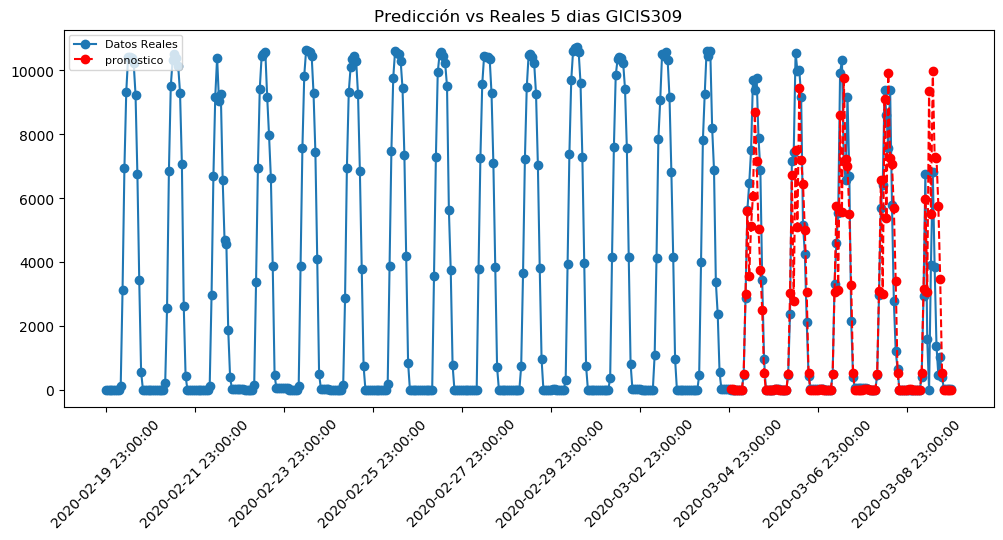

0    0.295393
dtype: float64


In [26]:
    arange_dates = []
    arange_no = []
    arange = datos[columna][-1-19*24:].index
    for i in range(0,len(arange),48):
        arange_dates.append(arange[i])
        arange_no.append(i)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(datos[columna][-1-19*24:], 'o-', label = 'Datos Reales')
    plt.plot(pronostico, 'o--', label='pronostico',color ='r')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.xticks(arange_no,arange_dates,rotation = 45)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print(mape_promedio)
    #print(fc)
    #print(model)

In [27]:
Forecasts = pd.DataFrame(fcc).dropna().T

In [28]:
Forecasts.index = test.index
Forecasts.columns = test.columns
round(Forecasts,2)

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,14.55,14.11,10.69,-0.0,-0.0,-0.0,-0.0,500.66,3012.34,5585.99,...,7152.06,4862.38,3751.83,2487.99,539.60,4.77,4.56,4.56,4.54,4.54
2020-03-06,14.55,14.11,10.40,-0.0,-0.0,-0.0,-0.0,488.48,3025.01,6733.96,...,7189.54,6410.09,5006.57,3062.42,514.59,4.22,3.95,3.95,3.92,3.92
2020-03-07,14.55,14.11,11.01,-0.0,-0.0,-0.0,-0.0,509.91,3074.75,5759.19,...,7227.01,7053.69,5491.48,3298.69,514.46,4.10,3.85,3.85,3.82,3.82
2020-03-08,14.55,14.11,16.03,-0.0,-0.0,-0.0,-0.0,507.09,3103.56,6564.39,...,7264.49,7240.56,5685.91,3406.27,532.70,3.86,3.60,3.60,3.57,3.57
2020-03-09,14.55,14.11,11.48,-0.0,-0.0,-0.0,-0.0,521.76,3144.19,5976.57,...,7301.97,7432.60,5770.72,3464.87,532.09,7.00,6.89,6.89,6.86,6.86


In [29]:
test

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,471.0,2869.0,5638.0,...,9765.0,7900.0,6890.0,3451.0,968.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,37.0,37.0,28.0,0.0,0.0,0.0,0.0,477.0,2390.0,7153.0,...,9180.0,5175.0,4259.0,2138.0,436.0,40.0,40.0,40.0,40.0,40.0
2020-03-07,40.0,40.0,20.0,0.0,0.0,0.0,0.0,483.0,3312.0,4590.0,...,6574.0,9176.0,6691.0,2148.0,412.0,44.0,44.0,44.0,44.0,44.0
2020-03-08,44.0,44.0,27.0,0.0,0.0,0.0,0.0,453.0,2972.0,5698.0,...,9392.0,5790.0,2777.0,1223.0,653.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,407.0,2934.0,6762.0,...,3838.0,1380.0,457.0,1025.0,408.0,14.0,14.0,14.0,14.0,14.0


In [30]:
new_mapes = np.abs((Forecasts - test) / test)
new_mapes[new_mapes == inf] = 0

In [31]:
new_mapes

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.062980,0.049961,0.009225,...,0.267582,0.384508,0.455467,0.279053,0.442562,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-06,0.606833,0.618584,0.628614,0.0,0.0,0.0,0.0,0.024067,0.265695,0.058582,...,0.216826,0.238665,0.175527,0.432375,0.180253,0.894480,0.901357,0.901357,0.902005,0.902005
2020-03-07,0.636320,0.647190,0.449703,0.0,0.0,0.0,0.0,0.055705,0.071635,0.254726,...,0.099333,0.231289,0.179274,0.535703,0.248685,0.906797,0.912571,0.912571,0.913164,0.913164
2020-03-08,0.669382,0.679264,0.406379,0.0,0.0,0.0,0.0,0.119401,0.044267,0.152052,...,0.226524,0.250528,1.047500,1.785175,0.184228,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-09,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.281961,0.071638,0.116153,...,0.902545,4.385944,11.627391,2.380363,0.304148,0.499759,0.507899,0.507899,0.509705,0.509705


In [32]:
new_mapes[[ 'Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]

,Hora 8,Hora 9,Hora 10,Hora 11,Hora 12,Hora 13,Hora 14,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19
2020-03-05,0.062980,0.049961,0.009225,0.447789,0.315204,0.372721,0.074492,0.267582,0.384508,0.455467,0.279053,0.442562
2020-03-06,0.024067,0.265695,0.058582,0.625046,0.289132,0.487869,0.056945,0.216826,0.238665,0.175527,0.432375,0.180253
2020-03-07,0.055705,0.071635,0.254726,0.434788,0.133418,0.459283,0.365349,0.099333,0.231289,0.179274,0.535703,0.248685
2020-03-08,0.119401,0.044267,0.152052,0.530596,0.029049,0.372776,0.311280,0.226524,0.250528,1.047500,1.785175,0.184228
2020-03-09,0.281961,0.071638,0.116153,0.930414,0.000000,0.414460,0.463907,0.902545,4.385944,11.627391,2.380363,0.304148


In [33]:
np.mean(new_mapes)

Hora 1     0.382507
Hora 2     0.389007
Hora 3     0.296939
Hora 4     0.000000
Hora 5     0.000000
Hora 6     0.000000
Hora 7     0.000000
Hora 8     0.108823
Hora 9     0.100639
Hora 10    0.118148
Hora 11    0.593727
Hora 12    0.153361
Hora 13    0.421422
Hora 14    0.254395
Hora 15    0.342562
Hora 16    1.098187
Hora 17    2.697031
Hora 18    1.082534
Hora 19    0.271975
Hora 20    0.460207
Hora 21    0.464366
Hora 22    0.464366
Hora 23    0.464975
Hora 24    0.464975
dtype: float64

In [34]:
np.mean(np.mean(new_mapes[['Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]))

0.6035668892389915